In [117]:
from matplotlib import pyplot as plt

In [118]:
cycle=1000
max_lr=0.5
halfcycle=cycle//2

In [119]:
no_of_cycles=4
total_iterations=no_of_cycles*cycle

In [120]:
y=[]
for i in range(total_iterations):
    if i%cycle>halfcycle:
        val=(max_lr/halfcycle)*(cycle-(i%cycle))
    else:
        val=(max_lr/halfcycle)*(i%cycle)
    
    y.append(val)

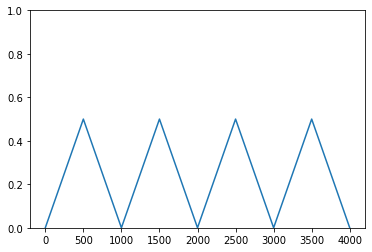

In [121]:
plt.plot(range(total_iterations),y,scaley=False)

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,**kwargs),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(),

In [4]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
# conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)

In [8]:
Conv2dAuto(32,64,kernel_size=4)

Conv2dAuto(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))

In [54]:

def conv_bn_relu(in_channels, out_channels, *args, **kwargs):

    return nn.Sequential(
                Conv2dAuto(in_channels=in_channels,out_channels=out_channels,**kwargs),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
            )
    
#     def forward(self,x):
#         return self.convblock(x)

# def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
#     return nn.Sequential(conv(in_channels, out_channels, *args, **kwargs), nn.BatchNorm2d(out_channels))


In [56]:
conv_bn_relu(3,32,kernel_size=3)

Sequential(
  (0): Conv2dAuto(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)

In [57]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Calculate Ture Mean and STD
def cifar10_mean_std():
    """Return the true mean of entire test and train dataset"""
    # simple transform
    simple_transforms = transforms.Compose([
                                           transforms.ToTensor(),
                                           ])
    exp_train = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=simple_transforms)
    exp_test = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=simple_transforms)

    exp_tr_data = exp_train.data # train set
    exp_ts_data = exp_test.data # test set

    exp_data = np.concatenate((exp_tr_data,exp_ts_data),axis=0) # contatenate entire data

    exp_data = np.transpose(exp_data,(3,1,2,0)) # reshape to (60000, 32, 32, 3)

    norm_mean = (np.mean(exp_data[0])/255, np.mean(exp_data[1])/255, np.mean(exp_data[2])/255)
    norm_std   = (np.std(exp_data[0])/255, np.std(exp_data[1])/255, np.std(exp_data[2])/255)

    return(tuple(map(lambda x: np.round(x,2), norm_mean)), tuple(map(lambda x: np.round(x,2), norm_std)))

def get_transforms(norm_mean,norm_std):
    """get the train and test transform"""
    print(norm_mean,norm_std)
    train_transform = transforms.Compose([transforms.RandomRotation(10) , transforms.RandomHorizontalFlip(0.20),
                                      transforms.ToTensor(),transforms.Normalize(norm_mean, norm_std)])
    test_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(norm_mean, norm_std)])
    return(train_transform,test_transform)

def get_datasets(train_transform,test_transform):
    """Extract and transform the data"""
    train_set = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=train_transform)
    test_set  = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=test_transform)
    return(train_set,test_set)

def get_dataloaders(train_set,test_set):
    """ Dataloader Arguments & Test/Train Dataloaders - Load part of ETL"""
    SEED = 1
    # CUDA?
    cuda = torch.cuda.is_available()
    print("CUDA Available?", cuda)
    # For reproducibility
    torch.manual_seed(SEED)
    if cuda:
        torch.cuda.manual_seed(SEED)
    # dataloader arguments
    dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64, num_workers=1)

    # train dataloader
    train_loader = torch.utils.data.DataLoader(train_set, **dataloader_args)
    # test dataloader
    test_loader  = torch.utils.data.DataLoader(test_set, **dataloader_args)
    return(train_loader,test_loader)

In [58]:
norm_mean,norm_std = cifar10_mean_std() #  (0.49, 0.48, 0.45), (0.25, 0.24, 0.26)
train_transform, test_transform = get_transforms(norm_mean,norm_std)

train,test=get_datasets(train_transform,test_transform)

Files already downloaded and verified
Files already downloaded and verified
(0.49, 0.48, 0.45) (0.25, 0.24, 0.26)
Files already downloaded and verified
Files already downloaded and verified


In [59]:
train_transform, test_transform =get_transforms(norm_mean,norm_std)
# (0.49, 0.48, 0.45) (0.25, 0.24, 0.26)

(0.49, 0.48, 0.45) (0.25, 0.24, 0.26)


In [60]:
torch.cuda.is_available()

True

In [61]:
# train_set,test_set = dataset.get_datasets(train_transform,test_transform)

# Targets -> ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = train.classes

# Dataloader Arguments & Test/Train Dataloaders - Load part of ETL
train_loader,test_loader = get_dataloaders(train,test)

CUDA Available? True


In [62]:
train_loader

In [70]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels=in_channels, out_channels
        self.blocks = nn.Identity()

        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x = nn.ReLU()(x)
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

In [71]:
class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=Conv2dAuto, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            nn.BatchNorm2d(self.expanded_channels)) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

In [72]:
class ResNetBasicBlock(ResNetResidualBlock):
    """
    Basic ResNet block composed by two layers of 3x3conv/batchnorm/activation
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn_relu(self.in_channels, self.out_channels,kernel_size=3,bias=False, stride=self.downsampling),
        
            conv_bn_relu(self.out_channels, self.expanded_channels,kernel_size=3,bias=False)
        )

In [73]:
ResNetBasicBlock(32,64)

ResNetBasicBlock(
  (blocks): Sequential(
    (0): Sequential(
      (0): Conv2dAuto(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (shortcut): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [80]:
dummy = torch.ones((1, 32, 224, 224))

In [82]:

ResNetBasicBlock(32,64)(dummy).shape

torch.Size([1, 64, 224, 224])